# Forbered Data 2

In [1]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import NearestNeighbors
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.neighbors import KNeighborsClassifier
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OrdinalEncoder
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

pd.options.display.max_columns = 1000
pd.options.display.max_info_columns = 1000
pd.options.display.max_info_rows = 1000
pd.options.display.max_rows = 50


In [2]:
pd.read_csv('data/sample_submission.csv')

,id,outcome
0,1235,lived
1,1236,lived
2,1237,lived
3,1238,lived
4,1239,lived
...,...,...
819,2054,lived
820,2055,lived
821,2056,lived
822,2057,lived


In [3]:
data = pd.read_csv('data/train.csv')



Jeg kan se at den data jeg har at arbejde med er labelled data. Labelled er 'outcome', hvor resten bortset fra id, er features som har en indflydelse på outcome. 

### Drop unødvendig data kolonner


In [4]:
if data.get('id') is not None:
    data = data.drop('id', axis=1)

#data = data.drop('hospital_number', axis=1)

data = data.drop('lesion_2', axis=1)
data = data.drop('lesion_3', axis=1)

# Manglende værdier

In [5]:
print(data.isna().sum())

surgery                    0
age                        0
hospital_number            0
rectal_temp                0
pulse                      0
respiratory_rate           0
temp_of_extremities       39
peripheral_pulse          60
mucous_membrane           21
capillary_refill_time      6
pain                      44
peristalsis               20
abdominal_distention      23
nasogastric_tube          80
nasogastric_reflux        21
nasogastric_reflux_ph      0
rectal_exam_feces        190
abdomen                  213
packed_cell_volume         0
total_protein              0
abdomo_appearance         48
abdomo_protein             0
surgical_lesion            0
lesion_1                   0
cp_data                    0
outcome                    0
dtype: int64


Her kan jeg se hvor mange manglende værdier der er for hver feature. Dem skal jeg have gjort noget ved.

In [6]:
categorical_columns = ['surgery', 'age','surgical_lesion','cp_data', 'temp_of_extremities','peripheral_pulse','mucous_membrane','capillary_refill_time', 'pain', 'peristalsis', 'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux', 'rectal_exam_feces', 'abdomen', 'abdomo_appearance', 'outcome']

In [7]:
encoder = OrdinalEncoder()

In [8]:
def encode(data_to_encode):
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data_to_encode.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode date
    impute_ordinal = encoder.fit_transform(impute_reshape)
    #Assign back encoded values to non-null values
    data_to_encode.loc[data_to_encode.notnull()] = np.squeeze(impute_ordinal)
    return data_to_encode

#create a for loop to iterate through each column in the data
for columns in categorical_columns:
    encode(data[columns])

C:\Users\chris\AppData\Local\Temp\ipykernel_1248\421248043.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_encode.loc[data_to_encode.notnull()] = np.squeeze(impute_ordinal)
C:\Users\chris\AppData\Local\Temp\ipykernel_1248\421248043.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_encode.loc[data_to_encode.notnull()] = np.squeeze(impute_ordinal)
C:\Users\chris\AppData\Local\Temp\ipykernel_1248\421248043.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in

In [9]:
X = data.drop(columns=['outcome'])
y = data['outcome']

data

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,pain,peristalsis,abdominal_distention,nasogastric_tube,nasogastric_reflux,nasogastric_reflux_ph,rectal_exam_feces,abdomen,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,cp_data,outcome
0,1.0,0.0,530001,38.1,132.0,24.0,1.0,3.0,2.0,2.0,1.0,0.0,3.0,2.0,0.0,6.5,1.0,1.0,57.0,8.5,2.0,3.4,1.0,2209,0.0,0.0
1,1.0,0.0,533836,37.5,88.0,12.0,1.0,2.0,4.0,2.0,3.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,33.0,64.0,2.0,2.0,1.0,2208,0.0,1.0
2,1.0,0.0,529812,38.3,120.0,28.0,1.0,3.0,5.0,1.0,2.0,3.0,0.0,2.0,2.0,3.5,NaN,0.0,37.0,6.4,2.0,3.4,1.0,5124,0.0,2.0
3,1.0,0.0,5262541,37.1,72.0,30.0,0.0,3.0,5.0,2.0,3.0,3.0,0.0,2.0,1.0,2.0,1.0,1.0,53.0,7.0,1.0,3.9,1.0,2208,1.0,2.0
4,0.0,0.0,5299629,38.0,52.0,48.0,2.0,2.0,3.0,1.0,0.0,3.0,1.0,2.0,0.0,7.0,3.0,3.0,47.0,7.3,1.0,2.6,0.0,0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,1.0,0.0,535246,38.5,129.0,48.0,1.0,3.0,5.0,2.0,1.0,0.0,0.0,0.0,1.0,2.0,NaN,0.0,57.0,66.0,2.0,2.0,1.0,2206,0.0,2.0
1231,1.0,0.0,528570,37.5,60.0,50.0,1.0,3.0,4.0,1.0,3.0,3.0,3.0,2.0,2.0,3.0,1.0,1.0,35.0,6.4,2.0,3.6,1.0,2209,1.0,0.0
1232,1.0,1.0,529685,37.5,84.0,40.0,2.0,3.0,3.0,1.0,3.0,3.0,3.0,2.0,2.0,3.0,2.0,2.0,40.0,5.9,1.0,7.0,1.0,400,1.0,2.0
1233,1.0,0.0,534784,38.1,70.0,16.0,2.0,3.0,1.0,1.0,3.0,3.0,3.0,0.0,1.0,2.0,0.0,1.0,58.0,74.0,1.0,2.0,1.0,2209,0.0,2.0


In [10]:
N_SPLITS = 4
regressor = RandomForestRegressor(random_state=0)

In [11]:
def get_scores_for_imputer(imputer, X_missing, y_missing):
    estimator = make_pipeline(imputer, regressor)
    impute_scores = cross_val_score(
        estimator, X_missing, y_missing, scoring="neg_mean_squared_error", cv=N_SPLITS
    )
    return impute_scores

x_labels = []

mses = np.zeros(4)
stds = np.zeros(4)

In [12]:
def get_full_score(X_full, y_full):
    full_scores = cross_val_score(
        regressor, X_full, y_full, scoring="neg_mean_squared_error", cv=N_SPLITS
    )
    return full_scores.mean(), full_scores.std()


mses[0], stds[0] = get_full_score(X, y)
x_labels.append("Full data")

In [13]:
def get_impute_knn_score(X_missing, y_missing):
    imputer = KNNImputer(missing_values=np.nan, add_indicator=True)
    knn_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return knn_impute_scores.mean(), knn_impute_scores.std()


mses[1], stds[1] = get_impute_knn_score(
    X, y
)

x_labels.append("KNN Imputation")

In [14]:
def get_impute_mean(X_missing, y_missing):
    imputer = SimpleImputer(missing_values=np.nan, strategy="mean", add_indicator=True)
    mean_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return mean_impute_scores.mean(), mean_impute_scores.std()


mses[2], stds[2] = get_impute_mean(
    X, y
)

x_labels.append("Mean Imputation")

In [15]:
def get_impute_iterative(X_missing, y_missing):
    imputer = IterativeImputer(
        missing_values=np.nan,
        add_indicator=True,
        random_state=0,
        n_nearest_features=3,
        max_iter=1,
        sample_posterior=True,
    )
    iterative_impute_scores = get_scores_for_imputer(imputer, X_missing, y_missing)
    return iterative_impute_scores.mean(), iterative_impute_scores.std()


mses[3], stds[3] = get_impute_iterative(
    X, y
)
x_labels.append("Iterative Imputation")

mses = mses * -1


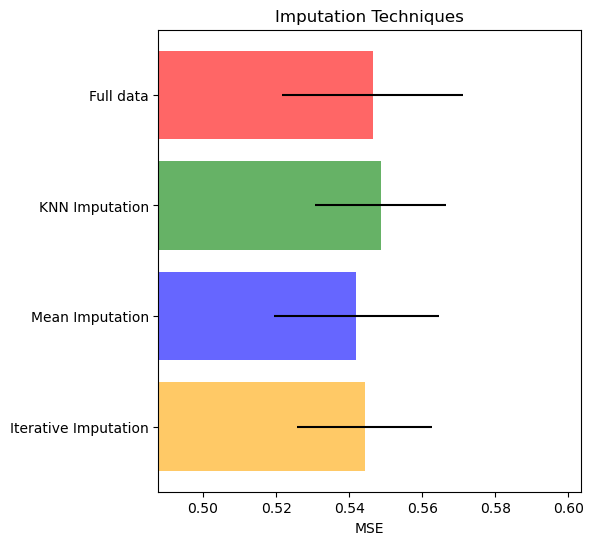

In [16]:
import matplotlib.pyplot as plt

n_bars = len(mses)
xval = np.arange(n_bars)

colors = ["r", "g", "b", "orange", "black"]

# plot diabetes results
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
for j in xval:
    ax1.barh(
        j,
        mses[j],
        xerr=stds[j],
        color=colors[j],
        alpha=0.6,
        align="center",
    )

ax1.set_title("Imputation Techniques")
ax1.set_xlim(left=np.min(mses) * 0.9, right=np.max(mses) * 1.1)
ax1.set_yticks(xval)
ax1.set_xlabel("MSE")
ax1.invert_yaxis()
ax1.set_yticklabels(x_labels)



plt.show()